# Stock Selection using Machine Learning Techniques - Part 2
by Chee-Foong（曾志峰）from Singapore（新加坡）on 28 Jul 2020

## Summary

This is a follow-up on an early [analysis](https://github.com/edgetrader/stock-selection-with-machine-learning/blob/master/notebook/csi300-stock-selection.ipynb).  Previously, we explored the portfolio performance Long-Only strategy based on monthly stock selection.  In this exercise, we studied the portfolio performance on weekly stock selection instead and allowed the portfolio to short securities when the model predicts a negative return in the week.

In short,
1.  Build a machine learning model to predict and categories 1-week returns of all securities in CSI 300.
2.  45 factors will be used as inputs to the model.  Type of factors includes: Quality, Fundamental, Emotional, Growth, Risk, Momentum, Technical, etc.
3.  Each predicted return will be categoried in A, B, C, D and E.  A being those that have more than 10% predicted returns and E being those that have less than -10% predicted returns.
4.  Portfolio will perform stock selection and rebalance its holding at the end of the week.  Rebalancing of the portfolio is based modern portfolio theory:  Minimum volatility on the efficient frontier of selected securities.
5.  This process will repeat every month and the strategy will be backtested to determine with whether the prediction model is good enough for consistent outperformance over the index/benchmark.

I welcome any comments/feedbacks on this analysis.  If you spot any mistakes, please let me know.


### References
Thank you to the authors of the following references for their work and sharing what they have done.
1. [A Sustainable Quantitative Stock Selection Strategy Based on Dynamic Factor Adjustment](https://www.researchgate.net/publication/341376900_A_Sustainable_Quantitative_Stock_Selection_Strategy_Based_on_Dynamic_Factor_Adjustment)
2. [Stock selection strategy of A-share market based on rotation effect and random forest](https://www.researchgate.net/publication/341596634_Stock_selection_strategy_of_A-share_market_based_on_rotation_effect_and_random_forest)

# Begin Analysis

## Preparing Datasets for Model Training

*Note that data extraction from JQData is not done in this analysis.  All data are loaded from csv files instead.*

---
### Loading the libraries

In [159]:
import time
import re
import random
import numpy as np
import pandas as pd
import os

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [143]:
JQ = False  ## Set to true if running on JQData Research Platform

def seedeverything(seed = 3333): 
    random.seed(seed) 
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    if JQ:
        tf.random.set_random_seed(seed)    
    else:
        tf.random.set_seed(seed) 
    
SEED = 3333
seedeverything(SEED)

### Loading saved data

1. **security_returns**:  Weekly returns of all securities in the benchmark
2. **security_list**:  Name and other references of all securities in the benchmark
3. **bmk_prices**:  Benchmark price series
4. **prices**:  Price series of all securities in the benchmark
5. **data**:  Calculated and consolidated return and factors of all securities over the whole period

In [144]:
if JQ:
    DATA_FOLDER = '../../factor-data-extraction/data-weekly/'
else:
    DATA_FOLDER = '../data-weekly/'

In [145]:
security_returns = pd.read_csv(DATA_FOLDER + 'security_returns.csv')
security_returns.date = pd.to_datetime(security_returns.date)
security_returns = security_returns.set_index(['date', 'factor'])
security_returns.columns.name = 'code'

In [146]:
data = pd.read_csv(DATA_FOLDER + 'full_data.csv')
data.date = pd.to_datetime(data.date)
data = data.set_index(['date', 'factor'])
data.columns.name = 'code'

In [147]:
security_list = pd.read_csv(DATA_FOLDER + 'security_ref.csv')
security_list = security_list.set_index(['symbol'])

In [148]:
bmk_prices = pd.read_csv(DATA_FOLDER + 'bmk_prices.csv')
bmk_prices.date = pd.to_datetime(bmk_prices.date)
bmk_prices = bmk_prices.set_index(['date'])

In [149]:
prices = pd.read_csv(DATA_FOLDER + 'security_prices.csv')
prices.date = pd.to_datetime(prices.date)
prices = prices.set_index(['date'])

## Preparing Training Data
Consolidate each monthly observations by features and their respective target in preparation for the training and testing dataset.

### Helper function
1. **getDataByDate**:  Extract returns and factors by date

In [150]:
def getDataByDate(date):
    idx = pd.IndexSlice
    out = data.loc[idx[date, :], :].T
    out.columns = out.columns.droplevel('date')
    out.columns.name = ''
    return out.reset_index()

Define training period to be from 2015 to 2017

In [153]:
train_startdate = '01-01-2015'
train_enddate = '01-01-2018'
sample_freq = 'W'

date_list = pd.date_range(train_startdate, train_enddate, freq=sample_freq).strftime("%Y-%m-%d").tolist()
print(date_list)

['2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25', '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22', '2015-03-01', '2015-03-08', '2015-03-15', '2015-03-22', '2015-03-29', '2015-04-05', '2015-04-12', '2015-04-19', '2015-04-26', '2015-05-03', '2015-05-10', '2015-05-17', '2015-05-24', '2015-05-31', '2015-06-07', '2015-06-14', '2015-06-21', '2015-06-28', '2015-07-05', '2015-07-12', '2015-07-19', '2015-07-26', '2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23', '2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20', '2015-09-27', '2015-10-04', '2015-10-11', '2015-10-18', '2015-10-25', '2015-11-01', '2015-11-08', '2015-11-15', '2015-11-22', '2015-11-29', '2015-12-06', '2015-12-13', '2015-12-20', '2015-12-27', '2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24', '2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21', '2016-02-28', '2016-03-06', '2016-03-13', '2016-03-20', '2016-03-27', '2016-04-03', '2016-04-10', '2016-04-17', '2016-04-24', '2016-05-01', '2016-05-08', '2016

Note that the data on the first and last month are not used for training for the following reasons:
- **first month**: Monthly return for the month cannot be calculated due to insufficient data
- **last month**: All data in the month will be used to predict the monthly return next month hence cannot be used for training the model

In [154]:
train = []
for date in date_list[1:-1]:
    out = getDataByDate(date)
    train.append(out)

train = pd.concat(train).reset_index(drop=True)

In [156]:
# import seaborn as sns
# sns.set()
# sns.pairplot(train, height = 2.5)
# plt.show()

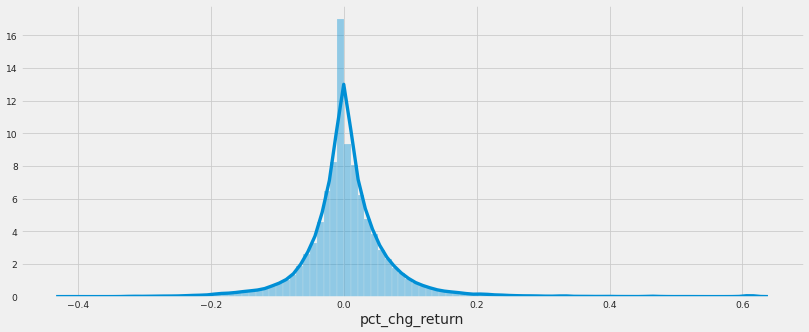

In [160]:
sns.distplot(train.pct_chg_return, 100)
plt.show()

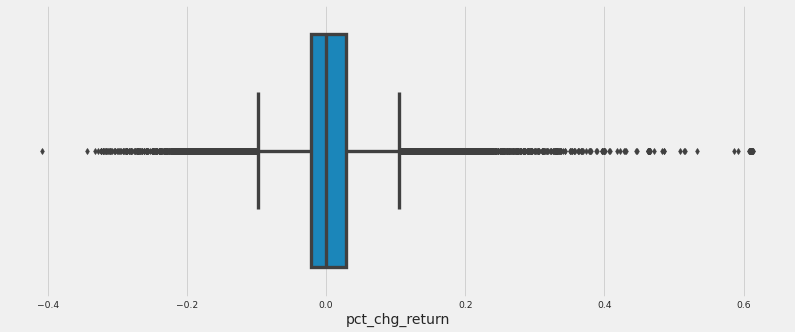

In [161]:
sns.boxplot(train.pct_chg_return)
plt.show()

In [162]:
train.pct_chg_return.describe()

count    40277.000000
mean         0.005088
std          0.067162
min         -0.409116
25%         -0.022163
50%          0.000000
75%          0.028424
max          0.614243
Name: pct_chg_return, dtype: float64

Correlation of the consolidated data

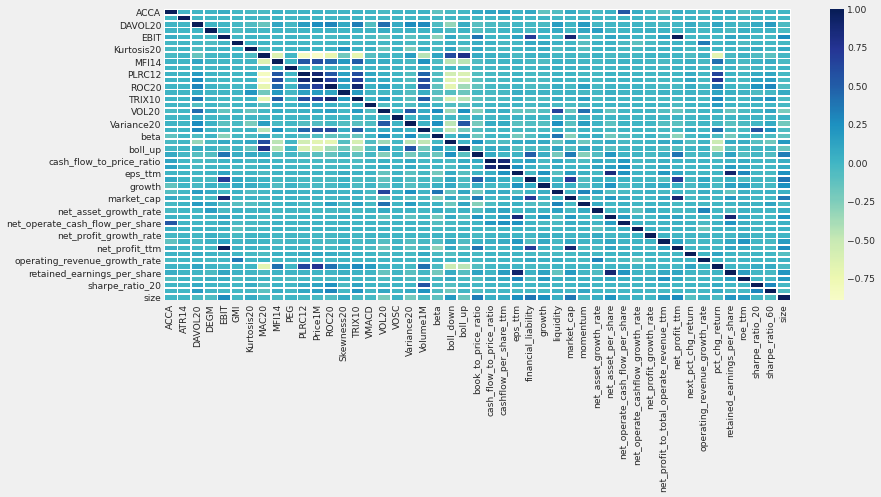

In [163]:
sns.heatmap(train.corr(), cmap="YlGnBu", center=0, linewidths=1, annot=False, fmt=".2f")
plt.show()

Removing observation with incomplete or missing data

In [164]:
train.dropna(axis=0, inplace=True)

In [165]:
security_todrop = train.groupby('code').size()
minsize = 52

security_todrop = security_todrop[security_todrop.values < minsize].index.tolist()
print('Number of securities dropped: {}'.format(len(security_todrop)))
train = train[~train.code.isin(security_todrop)]

Number of securities dropped: 52


Categorise the target to **return_range**.  

| Return Category | LabelEncoded | Description |
| :-: | :-: | --- |
| A | 0 | Stocks with next month return more than 10% |
| B | 1 | Stocks with next month return between 5% and 10% |
| C | 2 | Stocks with next month return between 0% and 5% |
| D | 3 | Stocks with next month return between -10% and 0% |
| E | 4 | Stocks with next month return less than -10% |


In [167]:
train['return_range'] = pd.cut(train['next_pct_chg_return'], 
       bins=[-float("inf"),-0.1,0,0.05,0.1,float("inf")], 
       right=False, labels=['E','D','C','B','A'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['return_range'] = le.fit_transform(train['return_range'])

Note that **code** will be dropped after resampling.

In [168]:
target = ['return_range']
to_drop = ['next_pct_chg_return']
features = [column for column in train.columns if column not in target + to_drop]

### Splitting into Training and Validation dataset

Split data first before resampling.  

In [169]:
X = train[features]
y = train[target]

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, 
                                                      stratify=y, random_state=SEED)

### Normalising the datasets
- Fit and Transform on the training dataset
- Transform only on the validation dataset using the scaler fitted with training dataset

In [171]:
col_toscale = X_train.columns.tolist()
col_toscale.remove('code')
print('List of columns to scale: {}'.format(col_toscale))

List of columns to scale: ['ACCA', 'ATR14', 'DAVOL20', 'DEGM', 'EBIT', 'GMI', 'Kurtosis20', 'MAC20', 'MFI14', 'PEG', 'PLRC12', 'Price1M', 'ROC20', 'Skewness20', 'TRIX10', 'VMACD', 'VOL20', 'VOSC', 'Variance20', 'Volume1M', 'beta', 'boll_down', 'boll_up', 'book_to_price_ratio', 'cash_flow_to_price_ratio', 'cashflow_per_share_ttm', 'eps_ttm', 'financial_liability', 'growth', 'liquidity', 'market_cap', 'momentum', 'net_asset_growth_rate', 'net_asset_per_share', 'net_operate_cash_flow_per_share', 'net_operate_cashflow_growth_rate', 'net_profit_growth_rate', 'net_profit_to_total_operate_revenue_ttm', 'net_profit_ttm', 'operating_revenue_growth_rate', 'pct_chg_return', 'retained_earnings_per_share', 'roe_ttm', 'sharpe_ratio_20', 'sharpe_ratio_60', 'size']


In [172]:
def processStdScaler(train, valid, columns):
    
    train_scaled = train.copy()
    valid_scaled = valid.copy()

    scaler = StandardScaler()
    scaler.fit(train[columns])
    train_scaled[columns] = scaler.transform(train[columns])
    valid_scaled[columns] = scaler.transform(valid[columns])

    return train_scaled, valid_scaled, scaler

In [173]:
X_train_std, X_valid_std, scaler = processStdScaler(X_train, X_valid, col_toscale)

In [174]:
X_train = X_train_std
X_valid = X_valid_std

### Resampling the Training dataset
Resampling is only done on the training dataset due to imbalanced target variable.  Upsampling will be done and be only conducted after the training dataset is normalised.

In [175]:
y_train.groupby('return_range').size()

return_range
0     789
1    1558
2    5467
3    5877
4     621
dtype: int64

In [176]:
y_train.return_range.value_counts()

3    5877
2    5467
1    1558
0     789
4     621
Name: return_range, dtype: int64

Observed imbalanced training data set as shown above

In [177]:
from sklearn.utils import resample

def upsample_byCol(data, column, code):
    maxN = data.groupby(column).size().max()

    df = data[data[column] == code]
    num = maxN - df.shape[0]
    if num > 0:
        df_more = resample(df, replace=True, n_samples=num, random_state=SEED)
        df = pd.concat([df, df_more])
    return df

Upsampling securities with fewer observations on training dataset only

In [178]:
Xy_train = pd.concat([X_train, y_train], axis = 1)

In [179]:
train_resample = []

return_ranges = Xy_train['return_range'].unique()
for return_range in return_ranges:
    code_resampled = upsample_byCol(Xy_train, 'return_range', return_range)
    train_resample.append(code_resampled)
    
Xy_train = pd.concat(train_resample).reset_index(drop=True)
Xy_train = Xy_train.sample(frac=1).reset_index(drop=True)

In [180]:
Xy_train.groupby('return_range').size()

return_range
0    5877
1    5877
2    5877
3    5877
4    5877
dtype: int64

After ensuring a balanced training dataset, prepare the features and target of the training and validation dataset respectively.

In [181]:
target = ['return_range']
to_drop = ['code']
features = [column for column in Xy_train.columns if column not in target + to_drop]

X_train = Xy_train[features]
y_train = Xy_train[target]

X_valid = X_valid[features]
y_valid = y_valid[target]

Prepare and check the class weights for model training later.

In [182]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train.return_range), 
                                                  np.array(y_train.return_range))
class_weights

array([1., 1., 1., 1., 1.])

### Prepare Training and Validation dataset for GridSearch

This will have to be done separately because we need the grid search to tune the parameters by validating against a dataset we provide and not automatically sampled from the training dataset that has been resampled.  We want samples in the validation dataset to be unseen in the training dataset.

In order to do this properly for GridSearchCV, we need to use PredefinedSplit and fit GridSearchCV with the full dataset.

In [183]:
Xy_trainGS = X_train.join(y_train)
Xy_validGS = X_valid.join(y_valid)

In [184]:
from sklearn.model_selection import PredefinedSplit

# Create a list where train data indices are -1 and validation data indices are 0
# eg: split_index = [-1 if x in X_train.index else 0 for x in X.index]
split_index = [-1] * Xy_trainGS.shape[0] + [0] * Xy_validGS.shape[0] 

# Use the list to create PredefinedSplit
pds_GridSearch = PredefinedSplit(test_fold = split_index)

In [185]:
Xy_GS = pd.concat([Xy_trainGS, Xy_validGS]).reset_index(drop=True) 
X_GS = Xy_GS[features]
y_GS = Xy_GS[target]

### One Hot Encoding for Target variable

*Not necessary of model training here*

In [186]:
# targetOHE = OneHotEncoder(sparse=False, handle_unknown='error')

# y_train_ohe = targetOHE.fit_transform(y_train)
# y_train_ohe = pd.DataFrame(y_train_ohe, columns=targetOHE.active_features_)
# print(y_train_ohe.shape)

# y_valid_ohe = targetOHE.transform(y_valid)
# y_valid_ohe = pd.DataFrame(y_valid_ohe, columns=targetOHE.active_features_)
# print(y_valid_ohe.shape)

In [187]:
# y_GS_ohe = targetOHE.transform(y_GS)
# y_GS_ohe = pd.DataFrame(y_GS_ohe, columns=targetOHE.active_features_)
# print(y_GS_ohe.shape)

### Finalising the Datasets

Keeping a copy of the validation target dataframe for confusion matrix later

In [188]:
X_valid_org = X_valid.copy()
y_valid_org = y_valid.copy()

Convert to numpy arrays for tensorflow keras model training  
*Not necessary for machine learning models here*

In [189]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_valid = np.array(X_valid)
# y_valid = np.array(y_valid)

# X_GS = np.array(X_GS)
# y_GS = np.array(y_GS)

In [190]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_GS.shape)
print(y_GS.shape)


(29385, 46)
(29385, 1)
(1591, 46)
(1591, 1)
(30976, 46)
(30976, 1)


Loading the model libraries

In [191]:
from lightgbm import LGBMClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_validate

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 

### Training Data test on trial model
Just to ensure the training dataset is constructed and transformed correctly

In [192]:
SEED = 3333

# evaluate the model
lgbm = LGBMClassifier()

# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=SEED)
n_scores = cross_val_score(lgbm, X_GS, y_GS, scoring='accuracy', cv=pds_GridSearch, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.390 (0.000)


## Model Building
### Hyperparameter tuning for various models

- Light GBM
- Random Forest
- Gradient Boosting Classifier
- XGBoost

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
models = [
    ('lgbm', LGBMClassifier()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('xgb', XGBClassifier())
]

n_estimators = [200]
max_features = [0.6, 0.8]
max_depth = [8, 10, 12]
learning_rate = [0.001, 0.0005]
subsample = [0.6, 0.8]
gamma = [0.01, 0.02, 0.03]
num_leaves = [10,15]

grid_param = [
    [{ ## lgbm
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'num_leaves': num_leaves,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'random_state': [SEED]  
    }],
    [{ ## rf
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'max_samples': subsample,
        'criterion': ['gini', 'entropy'],
        'oob_score': [True],
        'random_state': [SEED]
    }],
    [{ ## gb
        'n_estimators': n_estimators,
        'subsample': subsample,
        'max_features': max_features,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [SEED]
    }],
    [{ ## xgb
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'gamma': gamma,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'seed': [SEED]  
    }]
]


In [50]:
cv_split = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

In [51]:
start_total = time.perf_counter()

for model, param in zip (models, grid_param):

    print(model[1])
    print(param)
    
    start = time.perf_counter()        
    best_search = GridSearchCV(estimator=model[1], param_grid=param, 
                               cv=pds_GridSearch, scoring='accuracy', 
                               verbose=0, return_train_score=True)
    
    best_search.fit(X_GS, y_GS)
    
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('\n######')
    print('The best parameter for {} is {} with a runtime of {:.2f} minutes.'.format(model[1].__class__.__name__, 
                                                                                     best_param, run/60))
    model[1].set_params(**best_param) 

    print('######\n')

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[{'learning_rate': [0.001, 0.0005], 'max_depth': [8, 10, 12], 'n_estimators': [200], 'num_leaves': [10, 15], 'subsample': [0.6, 0.8], 'colsample_bytree': [0.6, 0.8], 'random_state': [3333]}]

######
The best parameter for LGBMClassifier is {'colsample_bytree': 0.6, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 15, 'random_state': 3333, 'subsample': 0.6} with a runtime of 1.97 minutes.
######

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', m

In [52]:
from tqdm import tqdm_notebook as tqdm

model_results = []
for m in tqdm(models):
    result = {}
    print('Processing {}...'.format(type(m[1]).__name__))

    m_cv = cross_validate(m[1], X_GS, y_GS, cv=pds_GridSearch, return_train_score=True)
    
    result['Model'] = type(m[1]).__name__
    result['TrainScore'] = m_cv['train_score'].mean()
    result['TestScore'] = m_cv['test_score'].mean()
    result['Test3Std'] = m_cv['test_score'].std()*3
    
    model_results.append(result)

Processing LGBMClassifier...
Processing RandomForestClassifier...
Processing GradientBoostingClassifier...
Processing XGBClassifier...



In [53]:
## Including Voting Classifier in the results    
## Hard Vote or majority rules w/Tuned Hyperparameters

print('Processing VotingClassifer...')
result = {}    
vc = VotingClassifier(estimators=models, voting='soft')
vc_cv = cross_validate(vc, X_GS, y_GS, cv=pds_GridSearch, return_train_score=True)

result['Model'] = type(vc).__name__
result['TrainScore'] = vc_cv['train_score'].mean()
result['TestScore'] = vc_cv['test_score'].mean()
result['Test3Std'] = vc_cv['test_score'].std()

model_results.append(result)

Processing VotingClassifer...


In [54]:
model_results = pd.DataFrame(model_results).set_index('Model').sort_values('TestScore', ascending=False) 
model_results

,TrainScore,TestScore,Test3Std
Model,,,
GradientBoostingClassifier,0.961205,0.420490,0.0
RandomForestClassifier,0.907810,0.415462,0.0
VotingClassifier,0.917271,0.413576,0.0
XGBClassifier,0.963791,0.408548,0.0
LGBMClassifier,0.462481,0.345695,0.0


In [55]:
# pd.DataFrame(model_results)

Testing Score is only around 0.40 and those models with Training Score of around 0.90 is too high and could be overfitting.

Selecting Voting Classifier model for model prediction and analysis

In [193]:
# best = models[1][1]
best = vc
best.fit(X_train, y_train)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=0.6,
                                             importance_type='split',
                                             learning_rate=0.001, max_depth=10,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=200, n_jobs=-1,
                                             num_leaves=15, objective=None,
                                             random_state=3333, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             sub...
                                            min_child_weig

In [194]:
predicted = best.predict(X_valid)

In [195]:
y_valid_org['predicted_range'] = predicted

In [197]:
if type(best).__name__ == 'LGBMClassifier':
    plot_importance(best, max_num_features=15)
    plt.show()
elif type(best).__name__ == 'VotingClassifier':
    pass
else:
    feat_importances = pd.Series(best.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
    plt.show()

### Model Performance

Confusion Matrix

In [199]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

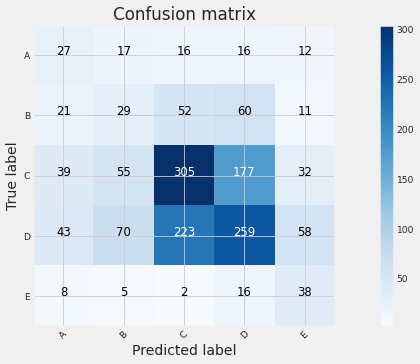

In [200]:
#importing confusion matrix

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_valid_org['return_range'], y_valid_org['predicted_range'])

plot_confusion_matrix(confusion, ['A','B','C','D','E'], False)
plt.show()

Classification Report

In [201]:
from sklearn.metrics import classification_report

print(classification_report(y_valid_org['return_range'], y_valid_org['predicted_range'], 
                            target_names=['A', 'B', 'C', 'D', 'E']))

              precision    recall  f1-score   support

           A       0.20      0.31      0.24        88
           B       0.16      0.17      0.17       173
           C       0.51      0.50      0.51       608
           D       0.49      0.40      0.44       653
           E       0.25      0.55      0.35        69

    accuracy                           0.41      1591
   macro avg       0.32      0.38      0.34      1591
weighted avg       0.44      0.41      0.42      1591



---
## Model Prediction

### Stock Selection by Trained Model
- Using the model trained on past 3 years data: 2015-2017, predict the stocks that may outperform on each week betweeen 2018 to 2020 using factors observed on previous week respectively.
- The top 10 securities in category A based on predicted probability will be selected for the week for investment.
- These securities will be sold end of the week and the new batch of securites will be selected.
- Transaction cost is ignored in this analysis.
- Potentially, the model should be retrained based on the recent data available and using the updated model to perform stock selection.  However, due to complexity in retraining the models, this is not done in this analysis.

### Helper Function
- **selectStockByWeek** : Function to perform stock selection at the start of the week.  Stock selection is done using the best model as defined above after training.  ***N*** number of stocks to long if they are expected to be in category A and ***N*** number of stocks to short if they are in category E.  Stocks are ranked by their probability in respective categories.  Highest probabilities one at the top.
- **getSecurityName** : Given symbol, retrieve the security name
- **getWeeklyReturn** : Given a date and symbol, get the weekly return for the security at that week
- **plotTimeSeries** : Plot the given time series
- **calcEFWeights** : Calculate the most efficient security weight based on efficient frontier of the selected securities at a given date


In [202]:
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

def selectStockByWeek(predictweek):

    dataweek = datetime.strptime(predictweek, '%Y-%m-%d') + relativedelta(weeks=-1)
    dataweek = dataweek.strftime("%Y-%m-%d")

    test = getDataByDate(dataweek).reset_index(drop=True)
    
    test.dropna(axis=0, inplace=True)

    to_drop = ['code', 'next_pct_chg_return']
    features = [column for column in test.columns if column not in to_drop]

    X = test[features]

    X_std = scaler.transform(X)
    X_std = pd.DataFrame(X_std, columns=X.columns)

    predicted_category = best.predict(X_std)
    predicted_probability = best.predict_proba(X_std)
    predicted_probability = np.max(predicted_probability, axis=1)

    results = pd.DataFrame(test.code)
    results['predictweek'] = predictweek
    results['predicted_range'] = predicted_category
    results['predicted_prob'] = predicted_probability
#     return results[results.predicted_range == 0].sort_values('predicted_prob', 
#                                                              ascending=False).head(10)

    CONFIDENCE = 0.25
    NUM_OF_STOCKS = 5
    CATEGORY_TO_LONG = 0
    CATEGORY_TO_SHORT = 4
    
    to_long = results[(results.predicted_range == CATEGORY_TO_LONG) & 
                      (results.predicted_prob > CONFIDENCE)].sort_values('predicted_prob', 
                                                             ascending=False).head(NUM_OF_STOCKS)
    to_short = results[(results.predicted_range == CATEGORY_TO_SHORT) & 
                       (results.predicted_prob > CONFIDENCE)].sort_values('predicted_prob', 
                                                             ascending=False).head(NUM_OF_STOCKS)
    return to_long, to_short

In [203]:
def getSecurityName(symbol):
    security = security_list.loc[symbol]
    return security.display_name, security.stock_name

def getWeeklyReturn(date, symbol):
    return security_returns.loc[pd.IndexSlice[date, :], symbol].values[0]

In [204]:
## CALCULATE BALANCED PORTFOLIO RETURN

# def calcPortfolioReturn(stock_returns):
    
#     num_stock = len(stock_returns)
#     ## Assume equally weighted portfolio
#     weights = np.ones(num_stock) / num_stock
    
#     return sum(weights * stock_returns)

In [205]:
from matplotlib import patheffects

def plotTimeSeries(series, title='', xlabel='', ylabel='', tickermap=''): 
    FIG_SIZE = (20,8)
    ax = series.plot(figsize=FIG_SIZE, fontsize=12, linewidth=3, linestyle='-')
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    
    title_text_obj = ax.set_title(title, fontsize = 18, verticalalignment = 'bottom')
    title_text_obj.set_path_effects([patheffects.withSimplePatchShadow()])
    # pe = patheffects.withSimplePatchShadow(offset = (1, -1), shadow_rgbFace = (1,0,0), calpha = 0.8)

    names = series.columns
    if tickermap:
        names = names.map(tickermap)
        
    ax.legend(names, fontsize = 16)
    plt.show()

In [206]:
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

def calcEFWeights(predictweek, code_list, min_vol=True):
    
    price_end_date = datetime.strptime(predictweek, '%Y-%m-%d') + relativedelta(days=-1)
    price_start_date = price_end_date + relativedelta(years=-1)
    
    historical_prices = prices.loc[price_start_date:price_end_date, code_list]

    # Calculate expected returns
    expected_returns_daily = expected_returns.mean_historical_return(historical_prices)

    # Calculate the covariance matrix
    covariance_matrix = risk_models.sample_cov(historical_prices)

    # Select a chosen optimal portfolio
    if min_vol:
        # Obtain the efficient frontier
        ef = EfficientFrontier(expected_returns_daily, covariance_matrix)
        ef.min_volatility()
    else:
        try:
            # Obtain the efficient frontier
            ef = EfficientFrontier(expected_returns_daily, covariance_matrix)
            ef.max_sharpe(risk_free_rate=0.00)
        except:
            print(predictweek)
            ef = EfficientFrontier(expected_returns_daily, covariance_matrix)
            ef.min_volatility()
        
    clean_weights = pd.DataFrame([ef.clean_weights()]).T
    clean_weights.columns = ['weights']
      
    # Obtain the performance numbers
    # ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)
    return clean_weights.weights

Creating the weeks for stock return predictions

In [207]:
predict_startdate = '2018-01-01'
predict_enddate = '2020-07-01'
predict_weeks = pd.date_range(predict_startdate, predict_enddate, freq=sample_freq). \
                        strftime("%Y-%m-%d").tolist()

In [208]:
print('Total number of weeks to predict: {}'.format(len(predict_weeks)))

Total number of weeks to predict: 130


Preparing the table of stocks to long and short in each week

In [209]:
predicted_tolong = []
predicted_toshort = []

for month in predict_weeks:
    try:
        to_long, to_short = selectStockByWeek(month)
        predicted_tolong.append(to_long)   
        predicted_toshort.append(to_short) 
    except:
        pass
        

Find the corresponging actual weekly returns of all the selected securities.  Multiply -1 to the returns of shorted securities.

In [210]:
predicted_tolong = pd.concat(predicted_tolong).reset_index(drop=True)
predicted_toshort = pd.concat(predicted_toshort).reset_index(drop=True)

if len(predicted_tolong) > 0:
    predicted_tolong['type'] = 'Long'
    predicted_tolong['weekly_returns'] = predicted_tolong.apply(
        lambda x: getWeeklyReturn(x['predictweek'], x['code']), axis=1)

if len(predicted_toshort) > 0:
    predicted_toshort['type'] = 'Short'
    predicted_toshort['weekly_returns'] = predicted_toshort.apply(
        lambda x: -1 * getWeeklyReturn(x['predictweek'], x['code']), axis=1)

predicted_results = pd.concat([predicted_tolong, predicted_toshort])
predicted_results['display_name'] = predicted_results['code'].apply(lambda x: getSecurityName(x)[0])
predicted_results['name'] = predicted_results['code'].apply(lambda x: getSecurityName(x)[1])

In [211]:
predicted_results = predicted_results.sort_values(['predictweek','type']).reset_index(drop=True)

Perform asset allocation with weights of securities in each week on the efficient frontier with minimum volatility.  Then calculate the total portfolio return for the week of all long and short positions and the actual weekly returns.

In [212]:
from collections import OrderedDict

MIN_VOL = True

pw_weeks = predicted_results.predictweek.unique().tolist()
portfolio_weekly_returns = []
predicted_results_with_wgts = []

for pw_week in pw_weeks:

    weekly_returns = OrderedDict({})
    list_to_long = predicted_results[(predicted_results.predictweek == pw_week) & 
                                     (predicted_results.type == 'Long')]
    list_to_short = predicted_results[(predicted_results.predictweek == pw_week) & 
                                      (predicted_results.type == 'Short')]
    
    long_returns = short_returns = 0 
    
    if len(list_to_long) > 1:
        long_weights = calcEFWeights(pw_week, list_to_long.code, MIN_VOL)
        long_returns = sum(list_to_long.weekly_returns * long_weights.values)
        list_to_long['weights'] = long_weights.values
    elif len(list_to_long) == 1:
        long_returns = sum(list_to_long.weekly_returns)
        list_to_long['weights'] = 1
        
    if len(list_to_short) > 1:
        short_weights = calcEFWeights(pw_week, list_to_short.code, MIN_VOL)
        short_returns = sum(list_to_short.weekly_returns * short_weights.values)
        list_to_short['weights'] = short_weights.values
    elif len(list_to_short) == 1:
        short_returns = sum(list_to_short.weekly_returns)
        list_to_short['weights'] = 1
        
    if (len(list_to_long) > 0) & (len(list_to_short) > 0):
        list_to_long['weights'] = list_to_long['weights'] / 2
        list_to_short['weights'] = list_to_short['weights'] / 2

    predicted_results_with_wgts.append(pd.concat([list_to_long, list_to_short]))
        
    aggregate_returns = (long_returns + short_returns)/2
    
    weekly_returns['predictweek'] = pw_week
    weekly_returns['weekly_returns'] = aggregate_returns
    
    portfolio_weekly_returns.append(weekly_returns)
    
portfolio_weekly_returns = pd.DataFrame(portfolio_weekly_returns)
portfolio_weekly_returns.set_index('predictweek', inplace=True)

Weekly transaction logs for checking purpose

In [213]:
weekly_transactions_logs = pd.concat(predicted_results_with_wgts)
weekly_transactions_logs.sort_index(inplace=True)


In [214]:
weekly_transactions_logs.head(50)

,code,predictweek,predicted_range,predicted_prob,type,weekly_returns,display_name,name,weights
0,601100.XSHG,2018-01-14,0,0.259802,Long,-0.000655,恒立液压,HLYY,1.000000
1,002714.XSHE,2018-01-21,0,0.258352,Long,0.016437,牧原股份,MYGF,1.000000
2,002714.XSHE,2018-02-04,0,0.255279,Long,-0.096939,牧原股份,MYGF,1.000000
3,300122.XSHE,2018-02-11,4,0.268469,Short,0.109214,智飞生物,ZFSW,0.406240
4,600516.XSHG,2018-02-11,4,0.264254,Short,0.016488,方大炭素,FDTS,0.244600
5,002146.XSHE,2018-02-11,4,0.263542,Short,0.223260,荣盛发展,RSFZ,0.349170
6,600176.XSHG,2018-02-18,4,0.376356,Short,-0.084746,中国巨石,ZGJS,0.223540
7,000671.XSHE,2018-02-18,4,0.374702,Short,-0.111576,阳光城,YGC,0.183920
8,603993.XSHG,2018-02-18,4,0.357270,Short,-0.086587,洛阳钼业,LYMY,0.042740
9,002146.XSHE,2018-02-18,4,0.356177,Short,-0.049180,荣盛发展,RSFZ,0.070950


In [215]:
### EQUALLY WEIGHTED

# portfolio_weekly_returns = predicted_results.groupby('predictweek')['weekly_returns'].agg(calcPortfolioReturn)
# portfolio_weekly_returns = pd.DataFrame(portfolio_weekly_returns)

Weekly portfolio returns and calculate the culmulative returns over the prediction period

In [216]:
portfolio_weekly_returns.index = pd.to_datetime(portfolio_weekly_returns.index)
portfolio_weekly_returns = pd.DataFrame(predict_weeks, columns=['predictweek']).set_index('predictweek'). \
                            join(portfolio_weekly_returns, how='left')
portfolio_weekly_returns.fillna(0, inplace=True)
portfolio_weekly_returns['cumulative_returns'] = ((1 + portfolio_weekly_returns).cumprod()-1) 

沪深300


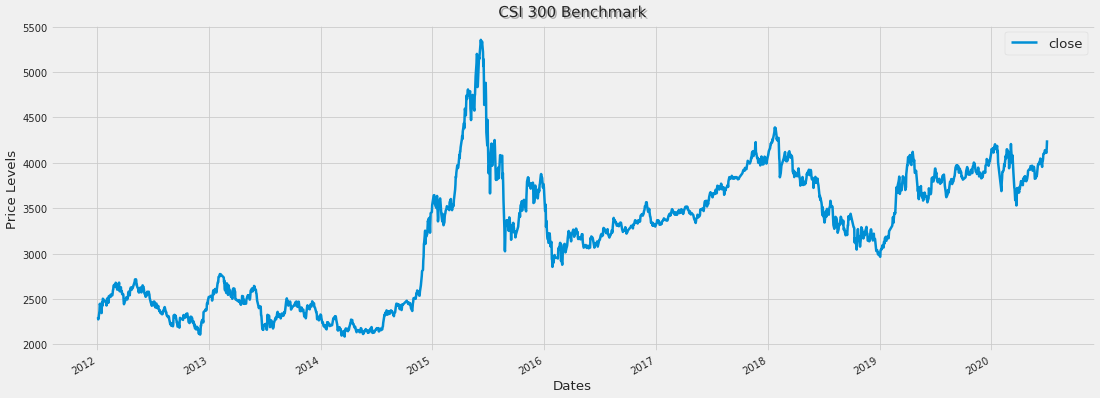

In [217]:
bmk_name = getSecurityName('000300.XSHG')[0]
print(bmk_name)
plotTimeSeries(bmk_prices, 'CSI 300 Benchmark', 'Dates', 'Price Levels')

Calculate benchmark returns and cumulative returns

In [218]:
bmk_prices = bmk_prices.resample(sample_freq).fillna('ffill')
bmk_returns = bmk_prices.pct_change().dropna(axis=0, how='all')
bmk_returns = pd.DataFrame(bmk_returns)
bmk_returns.columns = ['bmk_weekly_returns']
bmk_returns = bmk_returns['2018':'2020']
bmk_returns['bmk_cumulative_returns'] = ((1 + bmk_returns).cumprod()-1) 

Join portfolio and benckmark returns for comparison

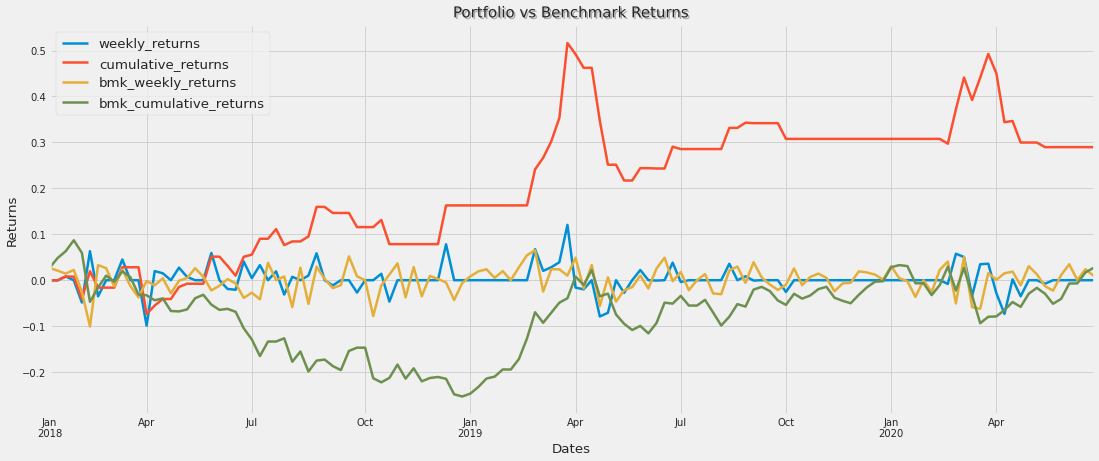

In [219]:
portfolio_weekly_returns = portfolio_weekly_returns.join(bmk_returns, how='left')
plotTimeSeries(portfolio_weekly_returns, 'Portfolio vs Benchmark Returns', 
               'Dates', 'Returns')

### Portfolio Performance

It is observed that the portfolio cumulative returns (red line) are consistently above the benchmark cumulative returns (green line).  On other words, the portfolio performance outperforms the benchmark consistently over the weeks.

In [220]:
portfolio_weekly_returns.to_csv('../output/portfolio_weekly_returns.csv', index=False)

In [221]:
weekly_transactions_logs.to_csv('../output/weekly_transactions_logs.csv', index=False)

## Concluding Notes

1. Model should be retrained on weekly basis with the most recent data to reflect the most market events.  I expect such retraining to contribute better portfolio performance especially during stress period.
2. Accuracy at around 40% is not fantastic.  Other models like AdaBoost, SVC, etc can be explored to see whether accuracy can improve.  On the other hand, we are only interested in stocks that falls into predicted range of 0 (predicted at least 10% monthly return), the portfolio performance still outperforms the benchmark consistently.
3. List of factors are selected based on the reference list found on the first research paper.  Other factors can be consider.  Important factors can be identified and updated on a weekly basis.  Can explore using only the top important factors to reduce noisy and overfitting.
4. This analysis focuses on data from JoinQuant and securities inside CSI300.  This can be easily extended to other securities found on different indices as long as the factor data are available.
5. Understanding the factors and respective calculation methodology provided by JoinQuant is important.  This will help in factor selection and explaining why the factors are selected for each time period.


# Thank you

Thanks to JoinQuant (聚宽) for providing such a platform and the necessary data for me to complete such an analysis.

In [222]:
# !pip install pyportfolioopt